# Classical feedforward and control flow

<details>
<summary><b>Package versions</b></summary>

The code on this page was developed using the following requirements.
We recommend using these versions or newer.

```
qiskit[all]~=2.0.0
```
</details>

<Admonition type="caution" title="Deprecations to accelerate the new version of dynamic circuits">

Starting 2 June 2025 and continuing through the year, IBM Quantum&reg; will begin a gradual rollout of new features to dynamic circuits that will enable them at the utility scale. See the [announcement](/announcements/product-updates/2025-03-03-new-version-dynamic-circuits) for more details.

As part of the rollout, the following have been removed:

- The `while`, `for`, and `switch` control flow constructs
- The ability to use control flow instructions inside the body of a branch (as in, nested control flow)
- Conditional measurements

New QPUs released after this deprecation will not support dynamic circuits until the updated features are released. Additionally, after the release, QPUs with older control electronics will not support dynamic circuits. To check whether a specific QPU supports dynamic circuits, use this code:

```python
# returns True if backend supports dynamic circuits
"dynamic_circuits" in backend.configuration().supported_features
```
</Admonition>

This guide demonstrates the functionality available in the Qiskit SDK for performing classical feedforward and control flow. These features are sometimes referred to collectively as "dynamic circuits." Classical feedforward refers to the ability to measure qubits in the middle of a circuit and perform additional quantum operations that depend on the measurement outcome. Qiskit supports four control flow constructs for classical feedforward, each implemented as a method on [`QuantumCircuit`](../api/qiskit/qiskit.circuit.QuantumCircuit). The constructs and their corresponding methods are:

- If statement - [`QuantumCircuit.if_test`](../api/qiskit/qiskit.circuit.QuantumCircuit#if_test)
- If statement - [`QuantumCircuit.if_else`](../api/qiskit/qiskit.circuit.QuantumCircuit#if_else)

Each of these methods returns a [context manager](https://docs.python.org/3/reference/datamodel.html#with-statement-context-managers) and is typically used in a `with` statement. In the rest of this guide, we will explain each of these constructs and how to use them.

<Admonition type="caution">
  - There are some limitations of classical feedforward and control flow operations on quantum hardware that might impact your program. For more information, see [Hardware considerations and limitations for classical feedforward and control flow](./dynamic-circuits-considerations).
  - Qiskit Runtime does not support all dynamic circuits features that Qiskit supports.  See the [QASM3 feature table](/docs/guides/qasm-feature-table) to determine which features are supported on Qiskit and Qiskit Runtime.
</Admonition>

## If statement

The if statement is used to conditionally perform operations based on the value of a classical bit or register.

In the example below, we apply a Hadamard gate to a qubit and measure it. If the result is 1, then we apply an X gate on the qubit, which has the effect of flipping it back to the 0 state. We then measure the qubit again. The resulting measurement outcome should be 0 with 100% probability.

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister

qubits = QuantumRegister(1)
clbits = ClassicalRegister(1)
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits

circuit.h(q0)
circuit.measure(q0, c0)
with circuit.if_test((c0, 1)):
    circuit.x(q0)
circuit.measure(q0, c0)
circuit.draw("mpl")

# example output counts: {'0': 1024}

<Image src="/docs/images/guides/classical-feedforward-and-control-flow/extracted-outputs/008f85d9-5b48-4e84-b250-846b07901607-0.svg" alt="Output of the previous code cell" />

The `with` statement can be given an assignment target which is itself a context manager that can be stored and subsequently used to create an else block, which is executed whenever the contents of the if block are *not* executed.

In the example below, we initialize registers with two qubits and two classical bits. We apply a Hadamard gate to the first qubit and measure it. If the result is 1, then we apply a Hadamard gate on the second qubit; otherwise, we apply an X gate on the second qubit. Finally, we measure the second qubit as well.

In [2]:
qubits = QuantumRegister(2)
clbits = ClassicalRegister(2)
circuit = QuantumCircuit(qubits, clbits)
(q0, q1) = qubits
(c0, c1) = clbits

circuit.h(q0)
circuit.measure(q0, c0)
with circuit.if_test((c0, 1)) as else_:
    circuit.h(q1)
with else_:
    circuit.x(q1)
circuit.measure(q1, c1)

circuit.draw("mpl")

# example output counts: {'01': 260, '11': 272, '10': 492}

<Image src="/docs/images/guides/classical-feedforward-and-control-flow/extracted-outputs/5b22ae93-27d1-4a0c-89e2-9f88383039d6-0.svg" alt="Output of the previous code cell" />

In addition to conditioning on a single classical bit, it's also possible to condition on the value of a classical register composed of multiple bits.

In the example below, we apply Hadamard gates to two qubits and measure them. If the result is `01`, that is, the first qubit is 1 and the second qubit is 0, then we apply an X gate to a third qubit. Finally, we measure the third qubit. Note that for clarity, we chose to specify the state of the third classical bit, which is 0, in the if condition. In the circuit drawing, the condition is indicated by the circles on the classical bits being conditioned on. A black circle indicates conditioning on 1, while a white circle indicates conditioning on 0.

In [3]:
qubits = QuantumRegister(3)
clbits = ClassicalRegister(3)
circuit = QuantumCircuit(qubits, clbits)
(q0, q1, q2) = qubits
(c0, c1, c2) = clbits

circuit.h([q0, q1])
circuit.measure(q0, c0)
circuit.measure(q1, c1)
with circuit.if_test((clbits, 0b001)):
    circuit.x(q2)
circuit.measure(q2, c2)

circuit.draw("mpl")

# example output counts: {'101': 269, '011': 260, '000': 252, '010': 243}

<Image src="/docs/images/guides/classical-feedforward-and-control-flow/extracted-outputs/15ac9465-c61f-4de1-81e8-e4edfafb07b4-0.svg" alt="Output of the previous code cell" />

## Classical expressions

Qiskit's classicial expresssion module [`qiskit.circuit.classical`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/circuit_classical) contains an exploratory representation of runtime operations on classical values during circuit execution. Currently, only simple expressions on bits and registers that result in a Boolean value are supported, and these are only valid for use in the conditions of `QuantumCircuit.if_test()` (`IfElseOp`) and `QuantumCircuit.while_loop()` (`WhileLoopOp`), and in the target of `QuantumCircuit.switch()` (`SwitchCaseOp`).

In the example below we show how the calculation of the parity can be used to create a n-qubit GHZ state using dynamic circuits.

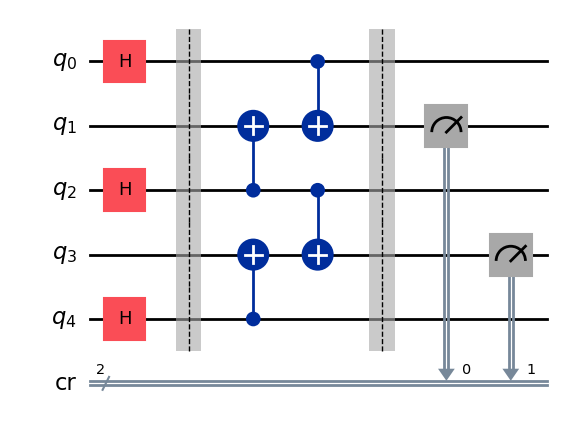

In [16]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

n=5
num_qubits = n
num_class_reg = int(n/2)

qr = QuantumRegister(num_qubits, name = "q") 
cr = ClassicalRegister(num_class_reg, name = "cr")
qc = QuantumCircuit(qr,cr)

for i in range(0, n, 2):
    qc.h(i)

qc.barrier()

for i in range(1, n, 2):
    qc.cx(i+1, i)

for i in range(0, n-1, 2):
    qc.cx(i,i+1)

qc.barrier()

for i in range(1, n-1, 2):
    index = int((i - 1)/2)
    qc.measure(i, cr[index])

qc.draw(output="mpl", style="iqp", idle_wires=False)



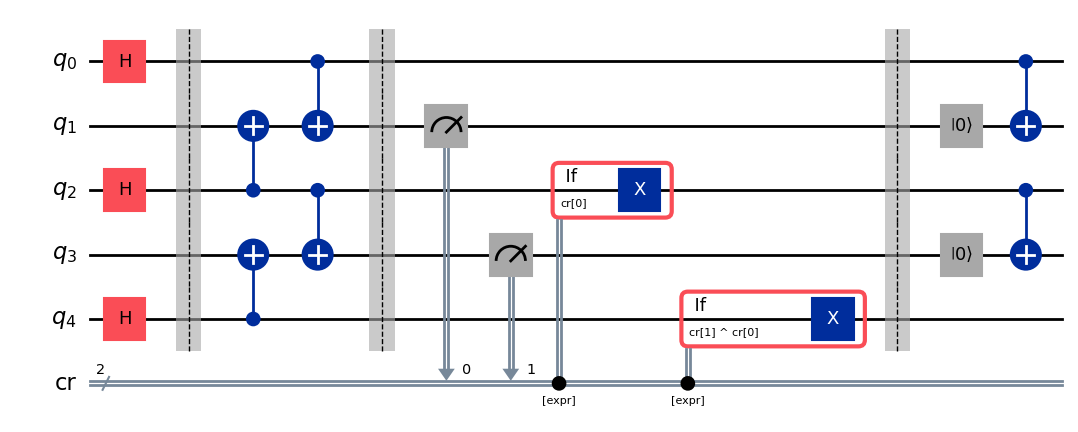

In [17]:
from qiskit.circuit.classical import expr

# For the parity expression
for i in range(1, n-1, 2):
    index = int((i + 1)/2)
    parity = expr.lift(cr[0])
    for j in range(1, index, 1):
        parity = expr.bit_xor(cr[j], parity)
    with qc.if_test(parity):
        qc.x(i+1)

qc.barrier()

for i in range(1, n-1, 2):
    qc.reset(i)

for i in range(1, n-1, 2):
    qc.cx(i-1, i)


qc.draw(output="mpl", style="iqp", idle_wires=False)

The first element of the constructed expression involves lifting the python object `cr[0]`to a [Value](https://docs.quantum.ibm.com/api/qiskit/0.44/circuit_classical#qiskit.circuit.classical.expr.Value)  node. This is not necessary for `cr[1]` and the possible following classical register as they are inputs to `expr.bit_xor` and any necessary lifting is done automatically in these cases. Such expressions can be build up in loops and other constructs.

## Limitations

Be aware of the following constraints when using dynamic circuits:

- Whenever you do a measure followed by an `if (c)`, the values that are measured and subsequently used in the if condition has a limit of **60 bits**.
- Nested conditionals are not allowed.
- Having `reset` inside conditionals is not supported.

## Next steps

<Admonition type="tip" title="Recommendations">
-  See an example of dynamic circuits in the [Repeat until success](https://learning.quantum.ibm.com/tutorial/repeat-until-success) tutorial.
- For considerations and limitations related to running dynamic circuits on quantum hardware, see the [Hardware considerations and limitations for classical feedforward and control flow](/docs/guides/dynamic-circuits-considerations) guide.
-  Review the [circuit library API](/docs/api/qiskit/circuit_library) reference.
</Admonition>